In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dense, Dropout, LSTM, Activation
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import backend

# from tensorflow.python.framework import ops
# ops.reset_default_graph()

# tensorflow version and keras version matters for compatability (latest versions not working together tensorflow 2.0 and keras 2.2.4)
# error message - AttributeError: module 'tensorflow' has no attribute 'get_default_graph'
# tensorflow 1.13.1 and keras 2.2.4 worked below

Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict

In [3]:
import datetime as dt
from dateutil.relativedelta import relativedelta

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy import desc

In [5]:
engine = create_engine("sqlite:///db/Veggie_Fruit_DB.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['fruitexportdest',
 'fruitexportval',
 'fruitimportsource',
 'fruitimportval',
 'veggieexportdest',
 'veggieexportval',
 'veggieimportsource',
 'veggieimportval']

In [8]:
inspector=inspect(engine)
inspector.get_table_names()

['fruitexportdest',
 'fruitexportval',
 'fruitimportsource',
 'fruitimportval',
 'veggieexportdest',
 'veggieexportval',
 'veggieimportsource',
 'veggieimportval']

In [9]:
measurement_columns = inspector.get_columns('fruitexportval')
for c in measurement_columns:
    print(c['name'])

id
product
flow
mktyr
avg
jan
feb
mar
apr
may
jun
jul
aug
sep
oct
nov
dec


In [10]:
# Save references to each table
# FED = FruistExportDestination, FEV =FruitExportValue, FIS =FruitImportSource,FIV=FruitImportValue
# VED =VeggieExportDestination, VEV=VeggieExportValue, VIS=VeggieImportSource, VIV=VeggieImportValue
FED = Base.classes.fruitexportdest
FEV = Base.classes.fruitexportval
FIS = Base.classes.fruitimportsource
FIV = Base.classes.fruitimportval
VED = Base.classes.veggieexportdest
VEV = Base.classes.veggieexportval
VIS = Base.classes.veggieimportsource
VIV = Base.classes.veggieimportval


In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [12]:
fev_summary = session.query(FEV.product,FEV.mktyr,FEV.jan,FEV.feb,FEV.mar,FEV.apr,FEV.may,FEV.jun,FEV.jul,FEV.aug,FEV.sep,FEV.oct,FEV.nov,FEV.dec).order_by(FEV.product.asc()).all()
fev_df = pd.DataFrame(fev_summary, columns=['product', 'mktyr', 'jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])


In [13]:
fev_df.head()

,product,mktyr,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
0,Apple,2019.0,"89,081","84,166","92,180",0,0,0,0,0,0,0,0,0
1,Apple,2018.0,"113,635","99,632","117,936","101,534","108,920","82,645","53,459","51,337","48,029","61,213","89,904","80,895"
2,Apple,2017.0,"84,874","87,895","95,203","74,945","82,806","76,525","56,665","53,621","55,600","75,074","127,769","98,522"
3,Apple,2016.0,"80,501","87,112","84,530","77,437","76,002","62,334","52,341","56,738","53,495","80,845","108,754","100,586"
4,Apple,2015.0,"111,979","83,135","101,106","90,883","99,848","71,933","69,759","67,186","59,125","81,440","99,990","82,272"


In [14]:
fev_df['jan'] = fev_df['jan'].str.replace(',', '')
fev_df['feb'] = fev_df['feb'].str.replace(',', '')
fev_df['mar'] = fev_df['mar'].str.replace(',', '')
fev_df['apr'] = fev_df['apr'].str.replace(',', '')
fev_df['may'] = fev_df['may'].str.replace(',', '')
fev_df['jun'] = fev_df['jun'].str.replace(',', '')
fev_df['jul'] = fev_df['jul'].str.replace(',', '')
fev_df['aug'] = fev_df['aug'].str.replace(',', '')
fev_df['sep'] = fev_df['sep'].str.replace(',', '')
fev_df['oct'] = fev_df['oct'].str.replace(',', '')
fev_df['nov'] = fev_df['nov'].str.replace(',', '')
fev_df['dec'] = fev_df['dec'].str.replace(',', '')


In [15]:
fev_df=fev_df.dropna(how="any")

In [16]:
fev_df["jan"] = pd.to_numeric(fev_df["jan"])
fev_df["feb"] = pd.to_numeric(fev_df["feb"])
fev_df["mar"] = pd.to_numeric(fev_df["mar"])
fev_df["apr"] = pd.to_numeric(fev_df["apr"])
fev_df["may"] = pd.to_numeric(fev_df["may"])
fev_df["jun"] = pd.to_numeric(fev_df["jun"])
fev_df["jul"] = pd.to_numeric(fev_df["jul"])
fev_df["aug"] = pd.to_numeric(fev_df["aug"])
fev_df["sep"] = pd.to_numeric(fev_df["sep"])
fev_df["oct"] = pd.to_numeric(fev_df["oct"])
fev_df["nov"] = pd.to_numeric(fev_df["nov"])
fev_df["dec"] = pd.to_numeric(fev_df["dec"])

In [17]:
fev_df.tail()

,product,mktyr,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
83,Pears,2015.0,21505,15001,13644,10299,8132,7412,10160,10844,19248,25402,26682,19393
100,Strawberries,2018.0,17496,27533,24395,43220,59794,49719,40222,40303,42563,39983,27254,15318
101,Strawberries,2017.0,14249,18296,29821,40112,50452,52969,44915,40847,40378,37616,25847,21020
102,Strawberries,2016.0,11004,20414,35624,35771,60551,49340,41845,41045,43948,31276,18475,16889
103,Strawberries,2015.0,22901,29747,38022,36743,55606,47085,38872,34588,34556,28249,12974,15629


In [18]:
vev_summary = session.query(VEV.product,VEV.mktyr,VEV.jan,VEV.feb,VEV.mar,VEV.apr,VEV.may,VEV.jun,VEV.jul,VEV.aug,VEV.sep,VEV.oct,VEV.nov,VEV.dec).order_by(VEV.product.asc()).all()
vev_df = pd.DataFrame(vev_summary, columns=['product', 'mktyr', 'jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])


In [19]:
vev_df.head()

,product,mktyr,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
0,Artichoke,2019.0,265,330,246,0,0,0,0,0,0,0,0,0
1,Artichoke,2018.0,323,366,235,268,326,269,179,187,206,195,334,329
2,Artichoke,2017.0,258,293,287,262,301,339,257,220,262,399,230,443
3,Artichoke,2016.0,122,230,295,449,182,306,262,167,269,296,332,391
4,Artichoke,2015.0,231,373,352,332,320,260,292,216,134,206,230,197


In [20]:
vev_df['jan'] = vev_df['jan'].str.replace(',', '')
vev_df['feb'] = vev_df['feb'].str.replace(',', '')
vev_df['mar'] = vev_df['mar'].str.replace(',', '')
vev_df['apr'] = vev_df['apr'].str.replace(',', '')
vev_df['may'] = vev_df['may'].str.replace(',', '')
vev_df['jun'] = vev_df['jun'].str.replace(',', '')
vev_df['jul'] = vev_df['jul'].str.replace(',', '')
vev_df['aug'] = vev_df['aug'].str.replace(',', '')
vev_df['sep'] = vev_df['sep'].str.replace(',', '')
vev_df['oct'] = vev_df['oct'].str.replace(',', '')
vev_df['nov'] = vev_df['nov'].str.replace(',', '')
vev_df['dec'] = vev_df['dec'].str.replace(',', '')

In [21]:
vev_df=vev_df.dropna(how="any")

In [22]:
vev_df["jan"] = pd.to_numeric(vev_df["jan"])
vev_df["feb"] = pd.to_numeric(vev_df["feb"])
vev_df["mar"] = pd.to_numeric(vev_df["mar"])
vev_df["apr"] = pd.to_numeric(vev_df["apr"])
vev_df["may"] = pd.to_numeric(vev_df["may"])
vev_df["jun"] = pd.to_numeric(vev_df["jun"])
vev_df["jul"] = pd.to_numeric(vev_df["jul"])
vev_df["aug"] = pd.to_numeric(vev_df["aug"])
vev_df["sep"] = pd.to_numeric(vev_df["sep"])
vev_df["oct"] = pd.to_numeric(vev_df["oct"])
vev_df["nov"] = pd.to_numeric(vev_df["nov"])
vev_df["dec"] = pd.to_numeric(vev_df["dec"])

In [23]:
vev_df.head()

,product,mktyr,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
11,Broccoli,2018.0,9423,8442,9187,10525,9467,9664,6865,6891,8128,8400,8584,9157
12,Broccoli,2017.0,8472,8197,8164,8933,9908,10528,7474,6586,5626,5586,9204,9472
13,Broccoli,2016.0,11011,8768,11019,13129,11740,10830,7156,7584,9029,10145,10362,8889
14,Broccoli,2015.0,10521,9769,10227,13467,13274,11550,8444,7708,8022,8552,8111,10317
16,Carrot,2018.0,7376,6403,9282,9089,9372,8738,6227,3320,2755,2982,4839,7347


In [24]:
e_frames = [vev_df, fev_df]
export_all = pd.concat(e_frames,ignore_index=False)

In [25]:
export_all.tail()

,product,mktyr,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
83,Pears,2015.0,21505,15001,13644,10299,8132,7412,10160,10844,19248,25402,26682,19393
100,Strawberries,2018.0,17496,27533,24395,43220,59794,49719,40222,40303,42563,39983,27254,15318
101,Strawberries,2017.0,14249,18296,29821,40112,50452,52969,44915,40847,40378,37616,25847,21020
102,Strawberries,2016.0,11004,20414,35624,35771,60551,49340,41845,41045,43948,31276,18475,16889
103,Strawberries,2015.0,22901,29747,38022,36743,55606,47085,38872,34588,34556,28249,12974,15629


In [26]:
export_all["year_sum"]=export_all["jan"]+export_all["feb"]+export_all["mar"]+export_all["jan"]+export_all["feb"]+export_all["mar"]+export_all["apr"]+export_all["may"]+export_all["jun"]+export_all["jul"]+export_all["aug"]+export_all["sep"]+export_all["oct"]+export_all["nov"]+export_all["dec"]

In [27]:
export_all.head(3)

,product,mktyr,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,year_sum
11,Broccoli,2018.0,9423,8442,9187,10525,9467,9664,6865,6891,8128,8400,8584,9157,131785
12,Broccoli,2017.0,8472,8197,8164,8933,9908,10528,7474,6586,5626,5586,9204,9472,122983
13,Broccoli,2016.0,11011,8768,11019,13129,11740,10830,7156,7584,9029,10145,10362,8889,150460


In [28]:
export_all["product"].nunique()

12

In [29]:
export_all.head()

,product,mktyr,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,year_sum
11,Broccoli,2018.0,9423,8442,9187,10525,9467,9664,6865,6891,8128,8400,8584,9157,131785
12,Broccoli,2017.0,8472,8197,8164,8933,9908,10528,7474,6586,5626,5586,9204,9472,122983
13,Broccoli,2016.0,11011,8768,11019,13129,11740,10830,7156,7584,9029,10145,10362,8889,150460
14,Broccoli,2015.0,10521,9769,10227,13467,13274,11550,8444,7708,8022,8552,8111,10317,150479
16,Carrot,2018.0,7376,6403,9282,9089,9372,8738,6227,3320,2755,2982,4839,7347,100791


In [30]:
broccoli_all = export_all[(export_all['product']=='Broccoli')]
# broc_2019 = pd.DataFrame({"product":["Broccoli"],"mktyr":["2019"], "jan":[0],"feb":[0],"mar":[0],"apr":[0],"may":[0],"jun":[0],"jul":[0],"aug":[0],"sep":[0],"oct":[0],"nov":[0],"dec":[0],"year_sum":[0]})
# broccoli_all.append(broc_2019).reset_index() 
broccoli_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Broccoli')].reset_index()
broccoli_2015_new = broccoli_2015[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_broccoli_2015 = broccoli_2015_new.rename(columns={"jan":"m1", "feb":"m2", "mar":"m3", "apr":"m4", "may":"m5", "jun":"m6", "jul":"m7","aug":"m8","sep":"m9","oct":"m10","nov":"m11", "dec":"m12"})
broccoli_2016 = export_all[(export_all['mktyr'] == 2016.0) & (export_all['product']=='Broccoli')].reset_index()
broccoli_2016_new = broccoli_2016[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_broccoli_2016 = broccoli_2016_new.rename(columns={"jan":"m13", "feb":"m14", "mar":"m15", "apr":"m16", "may":"m17", "jun":"m18", "jul":"m19","aug":"m20","sep":"m21","oct":"m22","nov":"m23", "dec":"m24"})
broccoli_2017 = export_all[(export_all['mktyr'] == 2017.0) & (export_all['product']=='Broccoli')].reset_index()
broccoli_2017_new = broccoli_2017[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_broccoli_2017 = broccoli_2017_new.rename(columns={"jan":"m25", "feb":"m26", "mar":"m27", "apr":"m28", "may":"m29", "jun":"m30", "jul":"m31","aug":"m32","sep":"m33","oct":"m34","nov":"m35", "dec":"m36"})
broccoli_2018 = export_all[(export_all['mktyr'] == 2018.0) & (export_all['product']=='Broccoli')].reset_index()
broccoli_2018_new = broccoli_2018[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_broccoli_2018 = broccoli_2018_new.rename(columns={"jan":"m37", "feb":"m38", "mar":"m39", "apr":"m40", "may":"m41", "jun":"m42", "jul":"m43","aug":"m44","sep":"m45","oct":"m46","nov":"m47", "dec":"m48"})


In [31]:
broc = ren_broccoli_2015.join([ren_broccoli_2016, ren_broccoli_2017, ren_broccoli_2018], how='outer')
trans_broc = broc.T 
broc_final = trans_broc.reset_index()
broc_data = broc_final.rename(columns={"index": "month", 0: "value"})
broc_data['mo'] = broc_data.index
broc_data.head()

,month,value,mo
0,m1,10521,0
1,m2,9769,1
2,m3,10227,2
3,m4,13467,3
4,m5,13274,4


In [32]:
broc_fin=broc_data[["mo", "value"]]
broc_fin.index = broc_fin.mo
broc_fin.drop('mo', axis=1, inplace=True)
broc_fin.head()
broc_fin.to_csv('dset/broc.csv')


/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [33]:
value = broc_data['value'].values
seq_len = 10
sequence_length = seq_len + 1

result = []
for index in range(len(value) - sequence_length):
    result.append(value[index: index + sequence_length])

In [34]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((33, 10, 1), (4, 10, 1))

In [35]:
model = Sequential()

model.add(LSTM(10, return_sequences=True, input_shape=(10, 1)))

model.add(LSTM(24, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', metrics=['mean_squared_error'],optimizer='nadam')

model.summary()

W1119 13:27:03.717476 4474488256 module_wrapper.py:139] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1119 13:27:03.727463 4474488256 module_wrapper.py:139] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1119 13:27:03.733680 4474488256 module_wrapper.py:139] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1119 13:27:04.298415 4474488256 module_wrapper.py:139] From /anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 10)            480       
_________________________________________________________________
lstm_2 (LSTM)                (None, 24)                3360      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 3,865
Trainable params: 3,865
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=100)

W1119 13:27:04.627799 4474488256 deprecation.py:323] From /anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1119 13:27:05.857563 4474488256 module_wrapper.py:139] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W1119 13:27:05.949453 4474488256 module_wrapper.py:139] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

W1119 13:27:06.127440 4474488256 module_wrapper.py:139] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W111

Train on 33 samples, validate on 4 samples
Epoch 1/100


W1119 13:27:06.394357 4474488256 module_wrapper.py:139] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:206: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



33/33 [==============================] - 2s 62ms/step - loss: 0.0657 - mean_squared_error: 0.0657 - val_loss: 0.0183 - val_mean_squared_error: 0.0183
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0601 - mean_squared_error: 0.0601 - val_loss: 0.0124 - val_mean_squared_error: 0.0124
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0550 - mean_squared_error: 0.0550 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 4/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0499 - mean_squared_error: 0.0499 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0444 - mean_squared_error: 0.0444 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0419 - mean_squared_error: 0.0419 - val_loss: 0.0105 - val_mean_squared_error: 0.0105
Epoch 7/100
33/33 [==========================

Epoch 52/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0350 - mean_squared_error: 0.0350 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 53/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0351 - mean_squared_error: 0.0351 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 54/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0349 - mean_squared_error: 0.0349 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 55/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0347 - mean_squared_error: 0.0347 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 56/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0347 - mean_squared_error: 0.0347 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 57/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0350 - mean_squared_error: 0.0350 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 58/100
33/33 [========

In [37]:
# Save the model
model.save("broc_model_trained.h5")

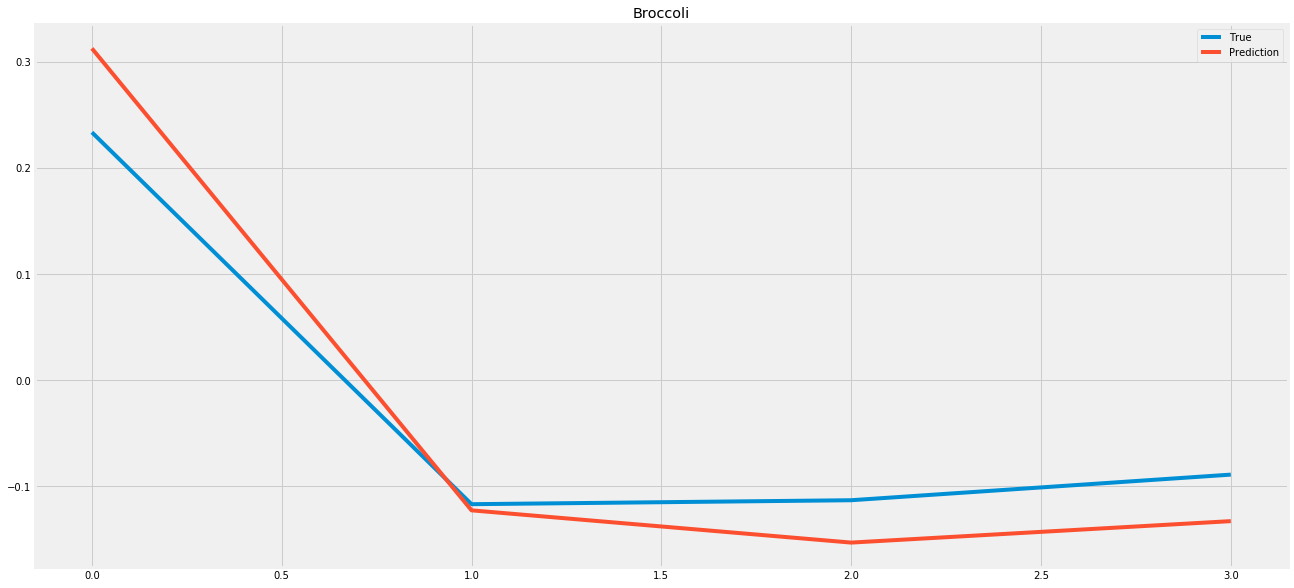

In [38]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
plt.title('Broccoli')
ax.legend()
plt.show()

In [39]:
carrot_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Carrot')]
carrot_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Carrot')].reset_index()
carrot_2015_new = carrot_2015[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_carrot_2015 = carrot_2015_new.rename(columns={"jan":"m1", "feb":"m2", "mar":"m3", "apr":"m4", "may":"m5", "jun":"m6", "jul":"m7","aug":"m8","sep":"m9","oct":"m10","nov":"m11", "dec":"m12"})
carrot_2016 = export_all[(export_all['mktyr'] == 2016.0) & (export_all['product']=='Carrot')].reset_index()
carrot_2016_new = carrot_2016[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_carrot_2016 = carrot_2016_new.rename(columns={"jan":"m13", "feb":"m14", "mar":"m15", "apr":"m16", "may":"m17", "jun":"m18", "jul":"m19","aug":"m20","sep":"m21","oct":"m22","nov":"m23", "dec":"m24"})
carrot_2017 = export_all[(export_all['mktyr'] == 2017.0) & (export_all['product']=='Carrot')].reset_index()
carrot_2017_new = carrot_2017[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_carrot_2017 = carrot_2017_new.rename(columns={"jan":"m25", "feb":"m26", "mar":"m27", "apr":"m28", "may":"m29", "jun":"m30", "jul":"m31","aug":"m32","sep":"m33","oct":"m34","nov":"m35", "dec":"m36"})
carrot_2018 = export_all[(export_all['mktyr'] == 2018.0) & (export_all['product']=='Carrot')].reset_index()
carrot_2018_new = carrot_2018[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_carrot_2018 = carrot_2018_new.rename(columns={"jan":"m37", "feb":"m38", "mar":"m39", "apr":"m40", "may":"m41", "jun":"m42", "jul":"m43","aug":"m44","sep":"m45","oct":"m46","nov":"m47", "dec":"m48"})


In [40]:
carr = ren_carrot_2015.join([ren_carrot_2016, ren_carrot_2017, ren_carrot_2018], how='outer')
trans_carr = carr.T 
carr_final = trans_carr.reset_index()
carr_data = carr_final.rename(columns={"index": "month", 0: "value"})
carr_data['mo'] = carr_data.index
carr_data.head()

,month,value,mo
0,m1,7804,0
1,m2,7198,1
2,m3,9948,2
3,m4,9790,3
4,m5,10273,4


In [41]:
carr_fin=carr_data[["mo", "value"]]
carr_fin.index = carr_fin.mo
carr_fin.drop('mo', axis=1, inplace=True)
carr_fin.to_csv('dset/carr.csv')


/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [42]:
value = carr_fin['value'].values
seq_len = 10
sequence_length = seq_len + 1

result = []
for index in range(len(value) - sequence_length):
    result.append(value[index: index + sequence_length])

In [43]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((33, 10, 1), (4, 10, 1))

In [44]:
model = Sequential()

model.add(LSTM(10, return_sequences=True, input_shape=(10, 1)))

model.add(LSTM(24, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', metrics=['mean_squared_error'],optimizer='nadam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10, 10)            480       
_________________________________________________________________
lstm_4 (LSTM)                (None, 24)                3360      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 25        
Total params: 3,865
Trainable params: 3,865
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=100)

Train on 33 samples, validate on 4 samples
Epoch 1/100
33/33 [==============================] - 2s 68ms/step - loss: 0.4248 - mean_squared_error: 0.4248 - val_loss: 0.1426 - val_mean_squared_error: 0.1426
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 0.3797 - mean_squared_error: 0.3797 - val_loss: 0.1603 - val_mean_squared_error: 0.1603
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 0.3470 - mean_squared_error: 0.3470 - val_loss: 0.2216 - val_mean_squared_error: 0.2216
Epoch 4/100
33/33 [==============================] - 0s 4ms/step - loss: 0.3047 - mean_squared_error: 0.3047 - val_loss: 0.3215 - val_mean_squared_error: 0.3215
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 0.2754 - mean_squared_error: 0.2754 - val_loss: 0.4149 - val_mean_squared_error: 0.4149
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 0.2595 - mean_squared_error: 0.2595 - val_loss: 0.4722 - val_mean_squared_erro

33/33 [==============================] - 0s 2ms/step - loss: 0.0395 - mean_squared_error: 0.0395 - val_loss: 0.0953 - val_mean_squared_error: 0.0953
Epoch 52/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0386 - mean_squared_error: 0.0386 - val_loss: 0.0777 - val_mean_squared_error: 0.0777
Epoch 53/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0379 - mean_squared_error: 0.0379 - val_loss: 0.1031 - val_mean_squared_error: 0.1031
Epoch 54/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0381 - mean_squared_error: 0.0381 - val_loss: 0.0852 - val_mean_squared_error: 0.0852
Epoch 55/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0797 - val_mean_squared_error: 0.0797
Epoch 56/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0477 - mean_squared_error: 0.0477 - val_loss: 0.1235 - val_mean_squared_error: 0.1235
Epoch 57/100
33/33 [=====================

In [46]:
model.save("carr_model_trained.h5")

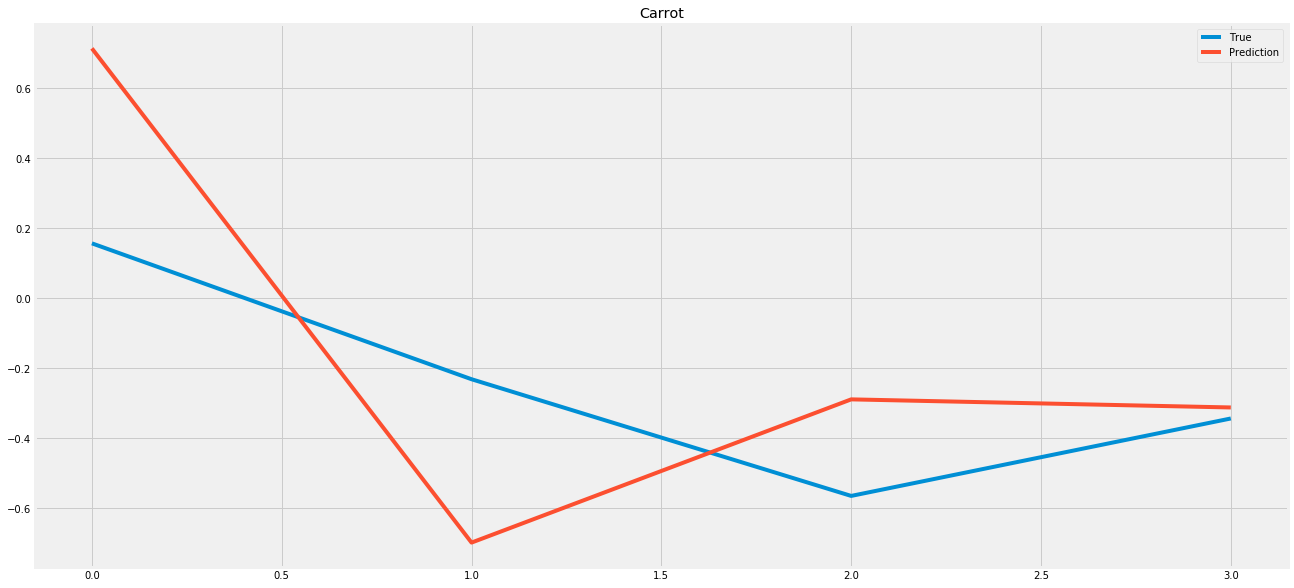

In [47]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
plt.title('Carrot')
ax.legend()
plt.show()

In [48]:
onion_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Onion')]
onn_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Onion')].reset_index()
onn_2015_new = onn_2015[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_onn_2015 = onn_2015_new.rename(columns={"jan":"m1", "feb":"m2", "mar":"m3", "apr":"m4", "may":"m5", "jun":"m6", "jul":"m7","aug":"m8","sep":"m9","oct":"m10","nov":"m11", "dec":"m12"})
onn_2016 = export_all[(export_all['mktyr'] == 2016.0) & (export_all['product']=='Onion')].reset_index()
onn_2016_new = onn_2016[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_onn_2016 = onn_2016_new.rename(columns={"jan":"m13", "feb":"m14", "mar":"m15", "apr":"m16", "may":"m17", "jun":"m18", "jul":"m19","aug":"m20","sep":"m21","oct":"m22","nov":"m23", "dec":"m24"})
onn_2017 = export_all[(export_all['mktyr'] == 2017.0) & (export_all['product']=='Onion')].reset_index()
onn_2017_new = onn_2017[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_onn_2017 = onn_2017_new.rename(columns={"jan":"m25", "feb":"m26", "mar":"m27", "apr":"m28", "may":"m29", "jun":"m30", "jul":"m31","aug":"m32","sep":"m33","oct":"m34","nov":"m35", "dec":"m36"})
onn_2018 = export_all[(export_all['mktyr'] == 2018.0) & (export_all['product']=='Onion')].reset_index()
onn_2018_new = onn_2018[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_onn_2018 = onn_2018_new.rename(columns={"jan":"m37", "feb":"m38", "mar":"m39", "apr":"m40", "may":"m41", "jun":"m42", "jul":"m43","aug":"m44","sep":"m45","oct":"m46","nov":"m47", "dec":"m48"})
onn = ren_onn_2015.join([ren_onn_2016, ren_onn_2017, ren_onn_2018], how='outer')


In [49]:
onn = ren_onn_2015.join([ren_onn_2016, ren_onn_2017, ren_onn_2018], how='outer')
trans_onn = broc.T 
onn_final = trans_onn.reset_index()
onn_data = onn_final.rename(columns={"index": "month", 0: "value"})
onn_data['mo'] = onn_data.index


In [50]:

# #creating dataframe
# onn_dt = onn_data.sort_index(ascending=True, axis=0)

# new_onn_dt = pd.DataFrame(index=range(0,len(onn_dt)),columns=['mo', 'value'])
# for i in range(0,len(onn_dt)):
#     new_onn_dt['mo'][i] = new_onn_dt['mo'][i]
#     new_onn_dt['value'][i] = new_onn_dt['value'][i]

#     #setting index
# new_onn_dt.index = new_onn_dt.mo
# new_onn_dt.drop('mo', axis=1, inplace=True)
# new_onn_dt
onn_fin=onn_data[["mo", "value"]]

In [51]:
onn_fin.index = onn_fin.mo
onn_fin.drop('mo', axis=1, inplace=True)
onn_fin.head()
onn_fin.to_csv('dset/onn.csv')

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [52]:
value = onn_fin["value"].values
seq_len = 10
sequence_length = seq_len + 1

result = []
for index in range(len(value) - sequence_length):
    result.append(value[index: index + sequence_length])

In [53]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((33, 10, 1), (4, 10, 1))

In [54]:
model = Sequential()

model.add(LSTM(10, return_sequences=True, input_shape=(10, 1)))

model.add(LSTM(24, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', metrics=['mean_squared_error'],optimizer='nadam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 10, 10)            480       
_________________________________________________________________
lstm_6 (LSTM)                (None, 24)                3360      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 3,865
Trainable params: 3,865
Non-trainable params: 0
_________________________________________________________________


In [55]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=100)

Train on 33 samples, validate on 4 samples
Epoch 1/100
33/33 [==============================] - 3s 81ms/step - loss: 0.0675 - mean_squared_error: 0.0675 - val_loss: 0.0206 - val_mean_squared_error: 0.0206
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0621 - mean_squared_error: 0.0621 - val_loss: 0.0155 - val_mean_squared_error: 0.0155
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0568 - mean_squared_error: 0.0568 - val_loss: 0.0095 - val_mean_squared_error: 0.0095
Epoch 4/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0514 - mean_squared_error: 0.0514 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0473 - mean_squared_error: 0.0473 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0446 - mean_squared_error: 0.0446 - val_loss: 0.0072 - val_mean_squared_erro

33/33 [==============================] - 0s 2ms/step - loss: 0.0355 - mean_squared_error: 0.0355 - val_loss: 0.0055 - val_mean_squared_error: 0.0055
Epoch 52/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0359 - mean_squared_error: 0.0359 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 53/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0354 - mean_squared_error: 0.0354 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 54/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0356 - mean_squared_error: 0.0356 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 55/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0350 - mean_squared_error: 0.0350 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 56/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0352 - mean_squared_error: 0.0352 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 57/100
33/33 [=====================

In [56]:
model.save("onn_model_trained.h5")

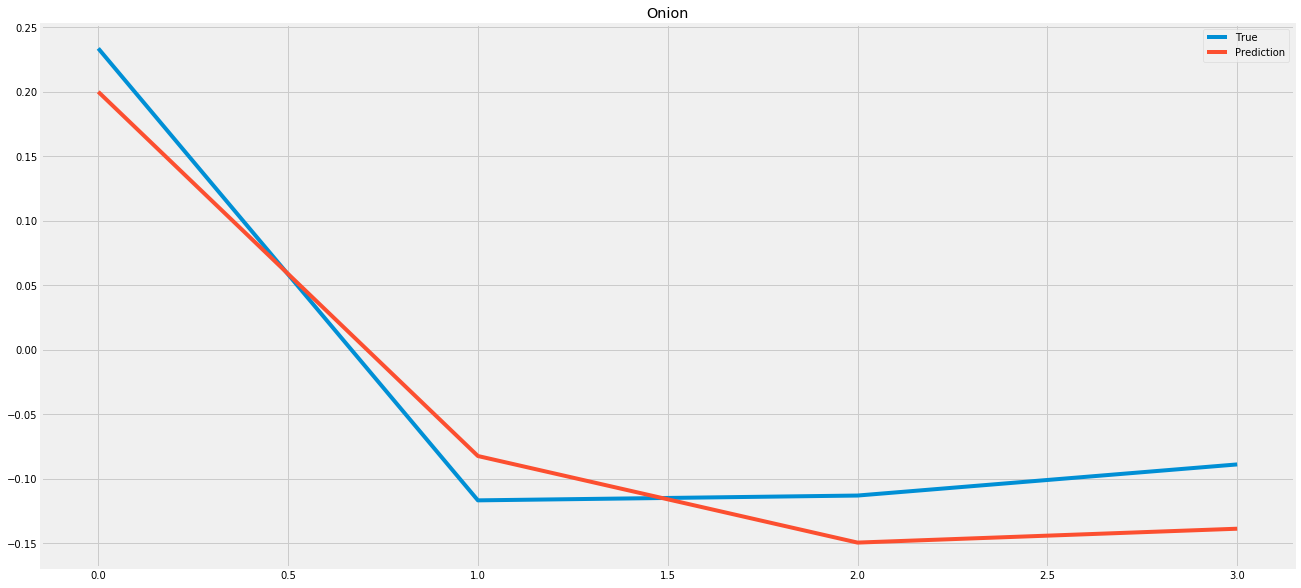

In [57]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
plt.title('Onion')
ax.legend()
plt.show()

In [58]:
pepper_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Pepper')]
pepp_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Pepper')].reset_index()
pepp_2015_new = pepp_2015[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_pepp_2015 = pepp_2015_new.rename(columns={"jan":"m1", "feb":"m2", "mar":"m3", "apr":"m4", "may":"m5", "jun":"m6", "jul":"m7","aug":"m8","sep":"m9","oct":"m10","nov":"m11", "dec":"m12"})
pepp_2016 = export_all[(export_all['mktyr'] == 2016.0) & (export_all['product']=='Onion')].reset_index()
pepp_2016_new = pepp_2016[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_pepp_2016 = pepp_2016_new.rename(columns={"jan":"m13", "feb":"m14", "mar":"m15", "apr":"m16", "may":"m17", "jun":"m18", "jul":"m19","aug":"m20","sep":"m21","oct":"m22","nov":"m23", "dec":"m24"})
pepp_2017 = export_all[(export_all['mktyr'] == 2017.0) & (export_all['product']=='Onion')].reset_index()
pepp_2017_new = pepp_2017[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_pepp_2017 = pepp_2017_new.rename(columns={"jan":"m25", "feb":"m26", "mar":"m27", "apr":"m28", "may":"m29", "jun":"m30", "jul":"m31","aug":"m32","sep":"m33","oct":"m34","nov":"m35", "dec":"m36"})
pepp_2018 = export_all[(export_all['mktyr'] == 2018.0) & (export_all['product']=='Onion')].reset_index()
pepp_2018_new = pepp_2018[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_pepp_2018 = pepp_2018_new.rename(columns={"jan":"m37", "feb":"m38", "mar":"m39", "apr":"m40", "may":"m41", "jun":"m42", "jul":"m43","aug":"m44","sep":"m45","oct":"m46","nov":"m47", "dec":"m48"})
pepp = ren_pepp_2015.join([ren_pepp_2016, ren_pepp_2017, ren_pepp_2018], how='outer')


In [59]:

trans_pepp = pepp.T 
pepp_final = trans_pepp.reset_index()
pepp_data = pepp_final.rename(columns={"index": "month", 0: "value"})
pepp_data['mo'] = pepp_data.index
pepp_fin=pepp_data[["mo", "value"]]
pepp_fin.index = pepp_fin.mo
pepp_fin.drop('mo', axis=1, inplace=True)
pepp_fin.to_csv('dset/pepp.csv')


/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [60]:
value = pepp_fin["value"].values
seq_len = 10
sequence_length = seq_len + 1

result = []
for index in range(len(value) - sequence_length):
    result.append(value[index: index + sequence_length])

In [61]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((33, 10, 1), (4, 10, 1))

In [62]:
model = Sequential()

model.add(LSTM(10, return_sequences=True, input_shape=(10, 1)))

model.add(LSTM(24, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', metrics=['mean_squared_error'],optimizer='nadam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 10, 10)            480       
_________________________________________________________________
lstm_8 (LSTM)                (None, 24)                3360      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 25        
Total params: 3,865
Trainable params: 3,865
Non-trainable params: 0
_________________________________________________________________


In [63]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=100)

Train on 33 samples, validate on 4 samples
Epoch 1/100
33/33 [==============================] - 3s 94ms/step - loss: 2.6690 - mean_squared_error: 2.6690 - val_loss: 0.1345 - val_mean_squared_error: 0.1345
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 2.5416 - mean_squared_error: 2.5416 - val_loss: 0.1161 - val_mean_squared_error: 0.1161
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 2.3650 - mean_squared_error: 2.3650 - val_loss: 0.0930 - val_mean_squared_error: 0.0930
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 2.1903 - mean_squared_error: 2.1903 - val_loss: 0.0686 - val_mean_squared_error: 0.0686
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 1.8933 - mean_squared_error: 1.8933 - val_loss: 0.0393 - val_mean_squared_error: 0.0393
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 1.5619 - mean_squared_error: 1.5619 - val_loss: 0.0297 - val_mean_squared_erro

33/33 [==============================] - 0s 2ms/step - loss: 0.1299 - mean_squared_error: 0.1299 - val_loss: 0.0659 - val_mean_squared_error: 0.0659
Epoch 52/100
33/33 [==============================] - 0s 2ms/step - loss: 0.1288 - mean_squared_error: 0.1288 - val_loss: 0.0656 - val_mean_squared_error: 0.0656
Epoch 53/100
33/33 [==============================] - 0s 2ms/step - loss: 0.1286 - mean_squared_error: 0.1286 - val_loss: 0.0662 - val_mean_squared_error: 0.0662
Epoch 54/100
33/33 [==============================] - 0s 2ms/step - loss: 0.1285 - mean_squared_error: 0.1285 - val_loss: 0.0629 - val_mean_squared_error: 0.0629
Epoch 55/100
33/33 [==============================] - 0s 2ms/step - loss: 0.1323 - mean_squared_error: 0.1323 - val_loss: 0.0632 - val_mean_squared_error: 0.0632
Epoch 56/100
33/33 [==============================] - 0s 2ms/step - loss: 0.1284 - mean_squared_error: 0.1284 - val_loss: 0.0649 - val_mean_squared_error: 0.0649
Epoch 57/100
33/33 [=====================

In [64]:
model.save("pepp_model_trained.h5")

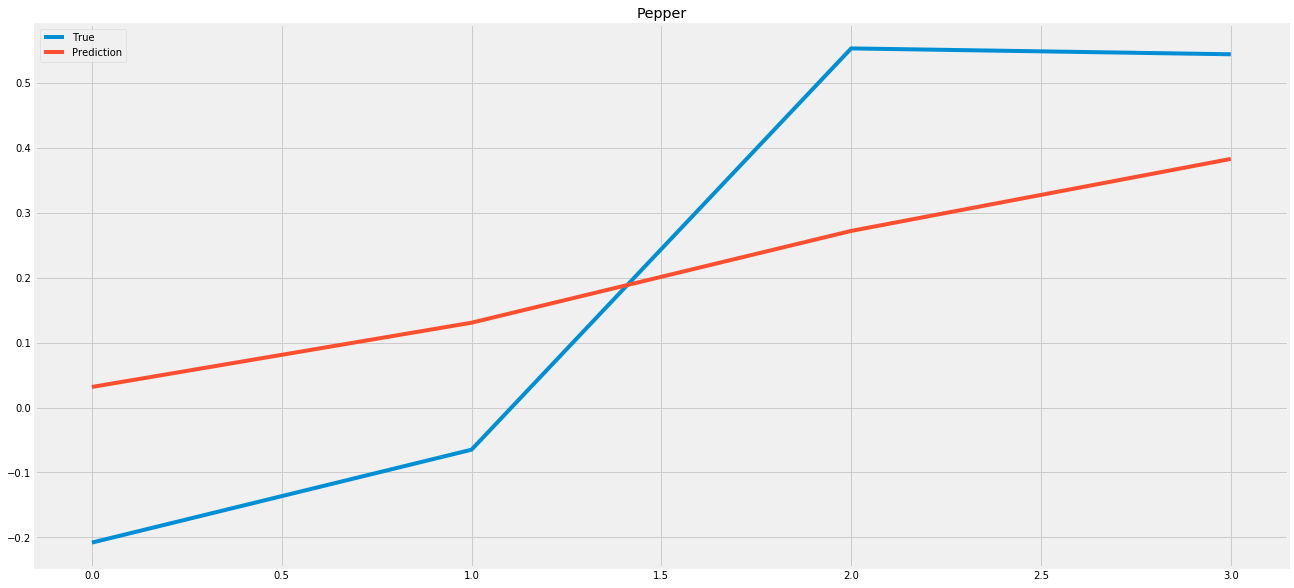

In [65]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
plt.title('Pepper')
ax.legend()
plt.show()

In [66]:
potato_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Potato')]
pot_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Potato')].reset_index()
pot_2015_new = pot_2015[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_pot_2015 = pot_2015_new.rename(columns={"jan":"m1", "feb":"m2", "mar":"m3", "apr":"m4", "may":"m5", "jun":"m6", "jul":"m7","aug":"m8","sep":"m9","oct":"m10","nov":"m11", "dec":"m12"})
pot_2016 = export_all[(export_all['mktyr'] == 2016.0) & (export_all['product']=='Onion')].reset_index()
pot_2016_new = pot_2016[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_pot_2016 = pot_2016_new.rename(columns={"jan":"m13", "feb":"m14", "mar":"m15", "apr":"m16", "may":"m17", "jun":"m18", "jul":"m19","aug":"m20","sep":"m21","oct":"m22","nov":"m23", "dec":"m24"})
pot_2017 = export_all[(export_all['mktyr'] == 2017.0) & (export_all['product']=='Onion')].reset_index()
pot_2017_new = pot_2017[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_pot_2017 = pot_2017_new.rename(columns={"jan":"m25", "feb":"m26", "mar":"m27", "apr":"m28", "may":"m29", "jun":"m30", "jul":"m31","aug":"m32","sep":"m33","oct":"m34","nov":"m35", "dec":"m36"})
pot_2018 = export_all[(export_all['mktyr'] == 2018.0) & (export_all['product']=='Onion')].reset_index()
pot_2018_new = pot_2018[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_pot_2018 = pot_2018_new.rename(columns={"jan":"m37", "feb":"m38", "mar":"m39", "apr":"m40", "may":"m41", "jun":"m42", "jul":"m43","aug":"m44","sep":"m45","oct":"m46","nov":"m47", "dec":"m48"})
pot = ren_pot_2015.join([ren_pot_2016, ren_pot_2017, ren_pot_2018], how='outer')


In [67]:
trans_pot = pot.T 
pot_final = trans_pot.reset_index()
pot_data = pot_final.rename(columns={"index": "month", 0: "value"})
pot_data['mo'] = pot_data.index
pot_fin=pot_data[["mo", "value"]]
pot_fin.index = pot_fin.mo
pot_fin.drop('mo', axis=1, inplace=True)
pot_fin.to_csv('dset/pot.csv')


/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [68]:
value = pot_fin["value"].values
seq_len = 10
sequence_length = seq_len + 1

result = []
for index in range(len(value) - sequence_length):
    result.append(value[index: index + sequence_length])

In [69]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((33, 10, 1), (4, 10, 1))

In [70]:
model = Sequential()

model.add(LSTM(10, return_sequences=True, input_shape=(10, 1)))

model.add(LSTM(24, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', metrics=['mean_squared_error'],optimizer='nadam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 10, 10)            480       
_________________________________________________________________
lstm_10 (LSTM)               (None, 24)                3360      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 3,865
Trainable params: 3,865
Non-trainable params: 0
_________________________________________________________________


In [71]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=100)

Train on 33 samples, validate on 4 samples
Epoch 1/100
33/33 [==============================] - 4s 107ms/step - loss: 0.0951 - mean_squared_error: 0.0951 - val_loss: 0.1280 - val_mean_squared_error: 0.1280
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0909 - mean_squared_error: 0.0909 - val_loss: 0.1212 - val_mean_squared_error: 0.1212
Epoch 3/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0886 - mean_squared_error: 0.0886 - val_loss: 0.1167 - val_mean_squared_error: 0.1167
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0868 - mean_squared_error: 0.0868 - val_loss: 0.1182 - val_mean_squared_error: 0.1182
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0844 - mean_squared_error: 0.0844 - val_loss: 0.1198 - val_mean_squared_error: 0.1198
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0810 - mean_squared_error: 0.0810 - val_loss: 0.1074 - val_mean_squared_err

33/33 [==============================] - 0s 2ms/step - loss: 0.0214 - mean_squared_error: 0.0214 - val_loss: 0.0190 - val_mean_squared_error: 0.0190
Epoch 52/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0223 - mean_squared_error: 0.0223 - val_loss: 0.0142 - val_mean_squared_error: 0.0142
Epoch 53/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0207 - mean_squared_error: 0.0207 - val_loss: 0.0160 - val_mean_squared_error: 0.0160
Epoch 54/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0211 - mean_squared_error: 0.0211 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 55/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0207 - mean_squared_error: 0.0207 - val_loss: 0.0177 - val_mean_squared_error: 0.0177
Epoch 56/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0213 - mean_squared_error: 0.0213 - val_loss: 0.0128 - val_mean_squared_error: 0.0128
Epoch 57/100
33/33 [=====================

In [72]:
model.save("pop_model_trained.h5")

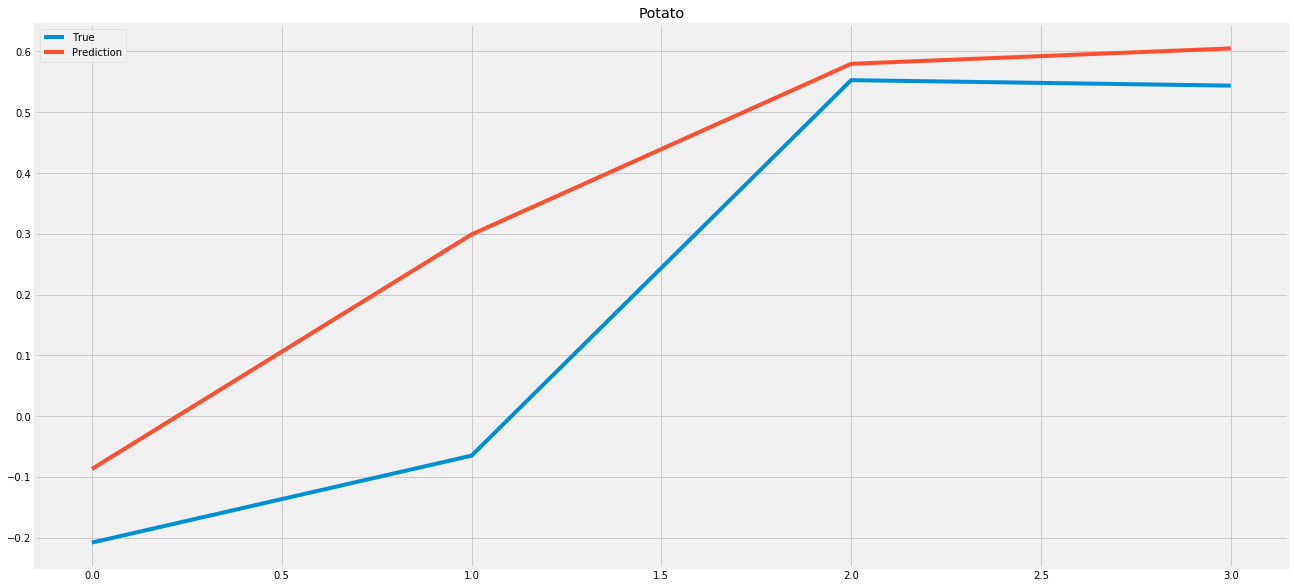

In [73]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
plt.title('Potato')
ax.legend()
plt.show()

In [74]:
apple_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Apple')]
app_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Potato')].reset_index()
app_2015_new = app_2015[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_app_2015 = app_2015_new.rename(columns={"jan":"m1", "feb":"m2", "mar":"m3", "apr":"m4", "may":"m5", "jun":"m6", "jul":"m7","aug":"m8","sep":"m9","oct":"m10","nov":"m11", "dec":"m12"})
app_2016 = export_all[(export_all['mktyr'] == 2016.0) & (export_all['product']=='Onion')].reset_index()
app_2016_new = app_2016[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_app_2016 = app_2016_new.rename(columns={"jan":"m13", "feb":"m14", "mar":"m15", "apr":"m16", "may":"m17", "jun":"m18", "jul":"m19","aug":"m20","sep":"m21","oct":"m22","nov":"m23", "dec":"m24"})
app_2017 = export_all[(export_all['mktyr'] == 2017.0) & (export_all['product']=='Onion')].reset_index()
app_2017_new = app_2017[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_app_2017 = app_2017_new.rename(columns={"jan":"m25", "feb":"m26", "mar":"m27", "apr":"m28", "may":"m29", "jun":"m30", "jul":"m31","aug":"m32","sep":"m33","oct":"m34","nov":"m35", "dec":"m36"})
app_2018 = export_all[(export_all['mktyr'] == 2018.0) & (export_all['product']=='Onion')].reset_index()
app_2018_new = app_2018[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_app_2018 = app_2018_new.rename(columns={"jan":"m37", "feb":"m38", "mar":"m39", "apr":"m40", "may":"m41", "jun":"m42", "jul":"m43","aug":"m44","sep":"m45","oct":"m46","nov":"m47", "dec":"m48"})
app = ren_app_2015.join([ren_app_2016, ren_app_2017, ren_app_2018], how='outer')


In [75]:
trans_app = app.T 
app_final = trans_app.reset_index()
app_data = app_final.rename(columns={"index": "month", 0: "value"})
app_data['mo'] = app_data.index
app_fin=app_data[["mo", "value"]]
app_fin.index = app_fin.mo
app_fin.drop('mo', axis=1, inplace=True)
app_fin.to_csv('dset/app.csv')

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [76]:
value = app_fin["value"].values
seq_len = 10
sequence_length = seq_len + 1

result = []
for index in range(len(value) - sequence_length):
    result.append(value[index: index + sequence_length])

In [77]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((33, 10, 1), (4, 10, 1))

In [78]:
model = Sequential()

model.add(LSTM(10, return_sequences=True, input_shape=(10, 1)))

model.add(LSTM(24, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', metrics=['mean_squared_error'],optimizer='nadam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 10, 10)            480       
_________________________________________________________________
lstm_12 (LSTM)               (None, 24)                3360      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 25        
Total params: 3,865
Trainable params: 3,865
Non-trainable params: 0
_________________________________________________________________


In [79]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=100)

Train on 33 samples, validate on 4 samples
Epoch 1/100
33/33 [==============================] - 4s 136ms/step - loss: 0.0960 - mean_squared_error: 0.0960 - val_loss: 0.1363 - val_mean_squared_error: 0.1363
Epoch 2/100
33/33 [==============================] - 0s 5ms/step - loss: 0.0940 - mean_squared_error: 0.0940 - val_loss: 0.1347 - val_mean_squared_error: 0.1347
Epoch 3/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0913 - mean_squared_error: 0.0913 - val_loss: 0.1364 - val_mean_squared_error: 0.1364
Epoch 4/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0900 - mean_squared_error: 0.0900 - val_loss: 0.1272 - val_mean_squared_error: 0.1272
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0888 - mean_squared_error: 0.0888 - val_loss: 0.1262 - val_mean_squared_error: 0.1262
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0866 - mean_squared_error: 0.0866 - val_loss: 0.1183 - val_mean_squared_err

33/33 [==============================] - 0s 2ms/step - loss: 0.0234 - mean_squared_error: 0.0234 - val_loss: 0.0166 - val_mean_squared_error: 0.0166
Epoch 52/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0235 - mean_squared_error: 0.0235 - val_loss: 0.0189 - val_mean_squared_error: 0.0189
Epoch 53/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0215 - val_mean_squared_error: 0.0215
Epoch 54/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0227 - mean_squared_error: 0.0227 - val_loss: 0.0157 - val_mean_squared_error: 0.0157
Epoch 55/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0664 - val_mean_squared_error: 0.0664
Epoch 56/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0239 - mean_squared_error: 0.0239 - val_loss: 0.0178 - val_mean_squared_error: 0.0178
Epoch 57/100
33/33 [=====================

In [80]:
model.save("app_model_trained.h5")

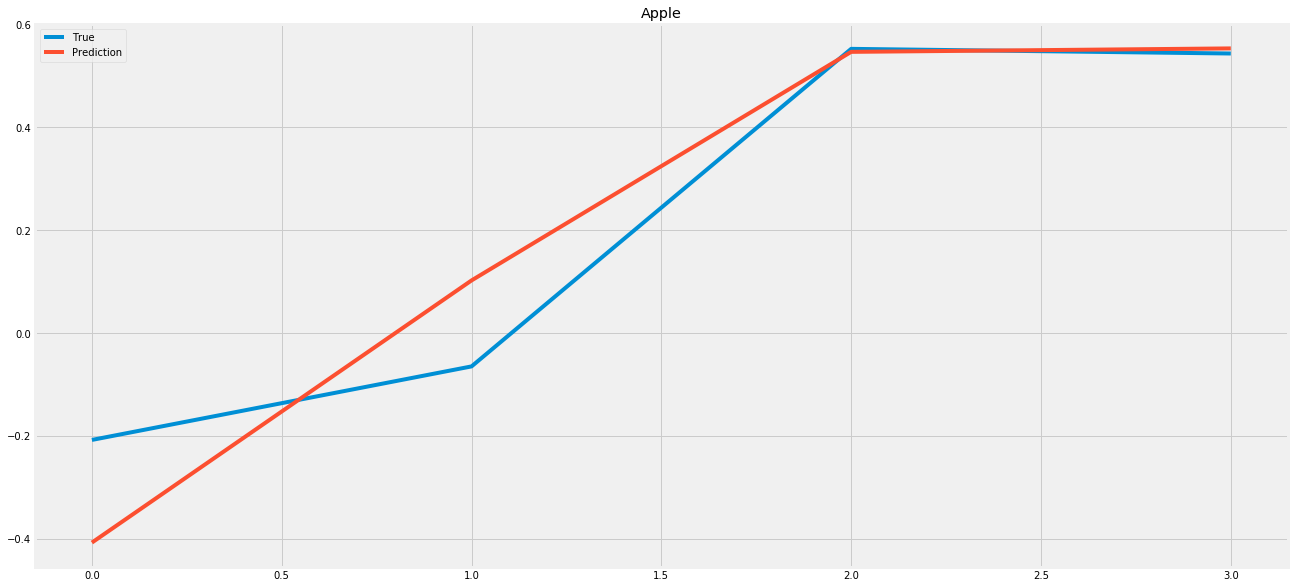

In [81]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
plt.title('Apple')
ax.legend()
plt.show()

In [82]:
grapes_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Grapes')]
grp_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Potato')].reset_index()
grp_2015_new = grp_2015[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_grp_2015 = grp_2015_new.rename(columns={"jan":"m1", "feb":"m2", "mar":"m3", "apr":"m4", "may":"m5", "jun":"m6", "jul":"m7","aug":"m8","sep":"m9","oct":"m10","nov":"m11", "dec":"m12"})
grp_2016 = export_all[(export_all['mktyr'] == 2016.0) & (export_all['product']=='Onion')].reset_index()
grp_2016_new = grp_2016[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_grp_2016 = grp_2016_new.rename(columns={"jan":"m13", "feb":"m14", "mar":"m15", "apr":"m16", "may":"m17", "jun":"m18", "jul":"m19","aug":"m20","sep":"m21","oct":"m22","nov":"m23", "dec":"m24"})
grp_2017 = export_all[(export_all['mktyr'] == 2017.0) & (export_all['product']=='Onion')].reset_index()
grp_2017_new = grp_2017[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_grp_2017 = grp_2017_new.rename(columns={"jan":"m25", "feb":"m26", "mar":"m27", "apr":"m28", "may":"m29", "jun":"m30", "jul":"m31","aug":"m32","sep":"m33","oct":"m34","nov":"m35", "dec":"m36"})
grp_2018 = export_all[(export_all['mktyr'] == 2018.0) & (export_all['product']=='Onion')].reset_index()
grp_2018_new = grp_2018[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_grp_2018 = grp_2018_new.rename(columns={"jan":"m37", "feb":"m38", "mar":"m39", "apr":"m40", "may":"m41", "jun":"m42", "jul":"m43","aug":"m44","sep":"m45","oct":"m46","nov":"m47", "dec":"m48"})
grp = ren_grp_2015.join([ren_grp_2016, ren_grp_2017, ren_grp_2018], how='outer')


In [83]:
trans_grp = grp.T 
grp_final = trans_grp.reset_index()
grp_data = grp_final.rename(columns={"index": "month", 0: "value"})
grp_data['mo'] = grp_data.index
grp_fin=grp_data[["mo", "value"]]
grp_fin.index = grp_fin.mo
grp_fin.drop('mo', axis=1, inplace=True)
grp_fin.to_csv('dset/grp.csv')

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [84]:
value = grp_fin["value"].values
seq_len = 10
sequence_length = seq_len + 1

result = []
for index in range(len(value) - sequence_length):
    result.append(value[index: index + sequence_length])

In [85]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((33, 10, 1), (4, 10, 1))

In [86]:
model = Sequential()

model.add(LSTM(10, return_sequences=True, input_shape=(10, 1)))

model.add(LSTM(24, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', metrics=['mean_squared_error'],optimizer='nadam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 10, 10)            480       
_________________________________________________________________
lstm_14 (LSTM)               (None, 24)                3360      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 25        
Total params: 3,865
Trainable params: 3,865
Non-trainable params: 0
_________________________________________________________________


In [87]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=100)

Train on 33 samples, validate on 4 samples
Epoch 1/100
33/33 [==============================] - 5s 138ms/step - loss: 0.1016 - mean_squared_error: 0.1016 - val_loss: 0.1450 - val_mean_squared_error: 0.1450
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0974 - mean_squared_error: 0.0974 - val_loss: 0.1344 - val_mean_squared_error: 0.1344
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0921 - mean_squared_error: 0.0921 - val_loss: 0.1234 - val_mean_squared_error: 0.1234
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0899 - mean_squared_error: 0.0899 - val_loss: 0.1244 - val_mean_squared_error: 0.1244
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0869 - mean_squared_error: 0.0869 - val_loss: 0.1179 - val_mean_squared_error: 0.1179
Epoch 6/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0860 - mean_squared_error: 0.0860 - val_loss: 0.1191 - val_mean_squared_err

33/33 [==============================] - 0s 3ms/step - loss: 0.0222 - mean_squared_error: 0.0222 - val_loss: 0.0376 - val_mean_squared_error: 0.0376
Epoch 52/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0243 - mean_squared_error: 0.0243 - val_loss: 0.0159 - val_mean_squared_error: 0.0159
Epoch 53/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0210 - mean_squared_error: 0.0210 - val_loss: 0.0208 - val_mean_squared_error: 0.0208
Epoch 54/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0212 - mean_squared_error: 0.0212 - val_loss: 0.0242 - val_mean_squared_error: 0.0242
Epoch 55/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0213 - mean_squared_error: 0.0213 - val_loss: 0.0145 - val_mean_squared_error: 0.0145
Epoch 56/100
33/33 [==============================] - 0s 5ms/step - loss: 0.0210 - mean_squared_error: 0.0210 - val_loss: 0.0154 - val_mean_squared_error: 0.0154
Epoch 57/100
33/33 [=====================

In [88]:
model.save("grp_model_trained.h5")

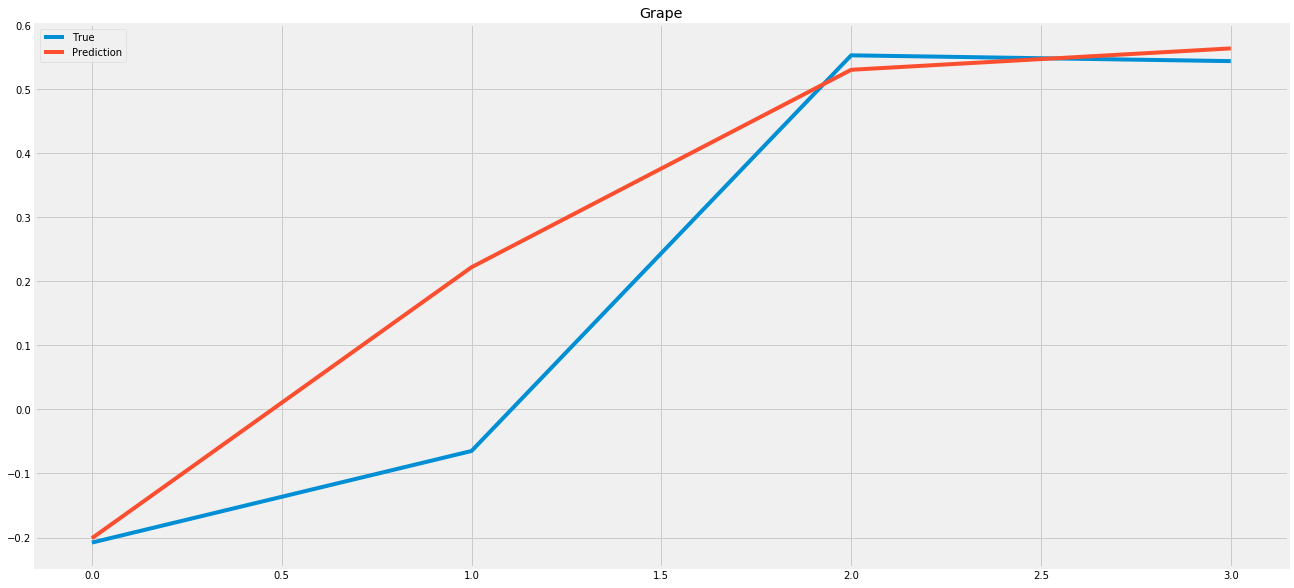

In [89]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
plt.title('Grape')
ax.legend()
plt.show()

In [90]:
orange_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Orange')]
orn_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Potato')].reset_index()
orn_2015_new = orn_2015[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_orn_2015 = orn_2015_new.rename(columns={"jan":"m1", "feb":"m2", "mar":"m3", "apr":"m4", "may":"m5", "jun":"m6", "jul":"m7","aug":"m8","sep":"m9","oct":"m10","nov":"m11", "dec":"m12"})
orn_2016 = export_all[(export_all['mktyr'] == 2016.0) & (export_all['product']=='Onion')].reset_index()
orn_2016_new = orn_2016[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_orn_2016 = orn_2016_new.rename(columns={"jan":"m13", "feb":"m14", "mar":"m15", "apr":"m16", "may":"m17", "jun":"m18", "jul":"m19","aug":"m20","sep":"m21","oct":"m22","nov":"m23", "dec":"m24"})
orn_2017 = export_all[(export_all['mktyr'] == 2017.0) & (export_all['product']=='Onion')].reset_index()
orn_2017_new = orn_2017[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_orn_2017 = orn_2017_new.rename(columns={"jan":"m25", "feb":"m26", "mar":"m27", "apr":"m28", "may":"m29", "jun":"m30", "jul":"m31","aug":"m32","sep":"m33","oct":"m34","nov":"m35", "dec":"m36"})
orn_2018 = export_all[(export_all['mktyr'] == 2018.0) & (export_all['product']=='Onion')].reset_index()
orn_2018_new = orn_2018[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_orn_2018 = orn_2018_new.rename(columns={"jan":"m37", "feb":"m38", "mar":"m39", "apr":"m40", "may":"m41", "jun":"m42", "jul":"m43","aug":"m44","sep":"m45","oct":"m46","nov":"m47", "dec":"m48"})
orn = ren_orn_2015.join([ren_orn_2016, ren_orn_2017, ren_orn_2018], how='outer')


In [91]:
trans_orn = orn.T 
orn_final = trans_orn.reset_index()
orn_data = orn_final.rename(columns={"index": "month", 0: "value"})
orn_data['mo'] = orn_data.index
orn_fin=orn_data[["mo", "value"]]
orn_fin.index = orn_fin.mo
orn_fin.drop('mo', axis=1, inplace=True)
orn_fin.to_csv('dset/orn.csv')

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [92]:
value = orn_fin["value"].values
seq_len = 10
sequence_length = seq_len + 1

result = []
for index in range(len(value) - sequence_length):
    result.append(value[index: index + sequence_length])

In [93]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((33, 10, 1), (4, 10, 1))

In [94]:
model = Sequential()

model.add(LSTM(10, return_sequences=True, input_shape=(10, 1)))

model.add(LSTM(24, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', metrics=['mean_squared_error'],optimizer='nadam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 10, 10)            480       
_________________________________________________________________
lstm_16 (LSTM)               (None, 24)                3360      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 25        
Total params: 3,865
Trainable params: 3,865
Non-trainable params: 0
_________________________________________________________________


In [95]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=100)

Train on 33 samples, validate on 4 samples
Epoch 1/100
33/33 [==============================] - 5s 157ms/step - loss: 0.1056 - mean_squared_error: 0.1056 - val_loss: 0.1502 - val_mean_squared_error: 0.1502
Epoch 2/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0996 - mean_squared_error: 0.0996 - val_loss: 0.1395 - val_mean_squared_error: 0.1395
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0967 - mean_squared_error: 0.0967 - val_loss: 0.1395 - val_mean_squared_error: 0.1395
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0957 - mean_squared_error: 0.0957 - val_loss: 0.1379 - val_mean_squared_error: 0.1379
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0929 - mean_squared_error: 0.0929 - val_loss: 0.1355 - val_mean_squared_error: 0.1355
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0905 - mean_squared_error: 0.0905 - val_loss: 0.1363 - val_mean_squared_err

33/33 [==============================] - 0s 3ms/step - loss: 0.0222 - mean_squared_error: 0.0222 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 52/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0215 - mean_squared_error: 0.0215 - val_loss: 0.0112 - val_mean_squared_error: 0.0112
Epoch 53/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0218 - mean_squared_error: 0.0218 - val_loss: 0.0119 - val_mean_squared_error: 0.0119
Epoch 54/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0220 - mean_squared_error: 0.0220 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 55/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0218 - mean_squared_error: 0.0218 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 56/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0219 - mean_squared_error: 0.0219 - val_loss: 0.0235 - val_mean_squared_error: 0.0235
Epoch 57/100
33/33 [=====================

In [96]:
model.save("orn_model_trained.h5")

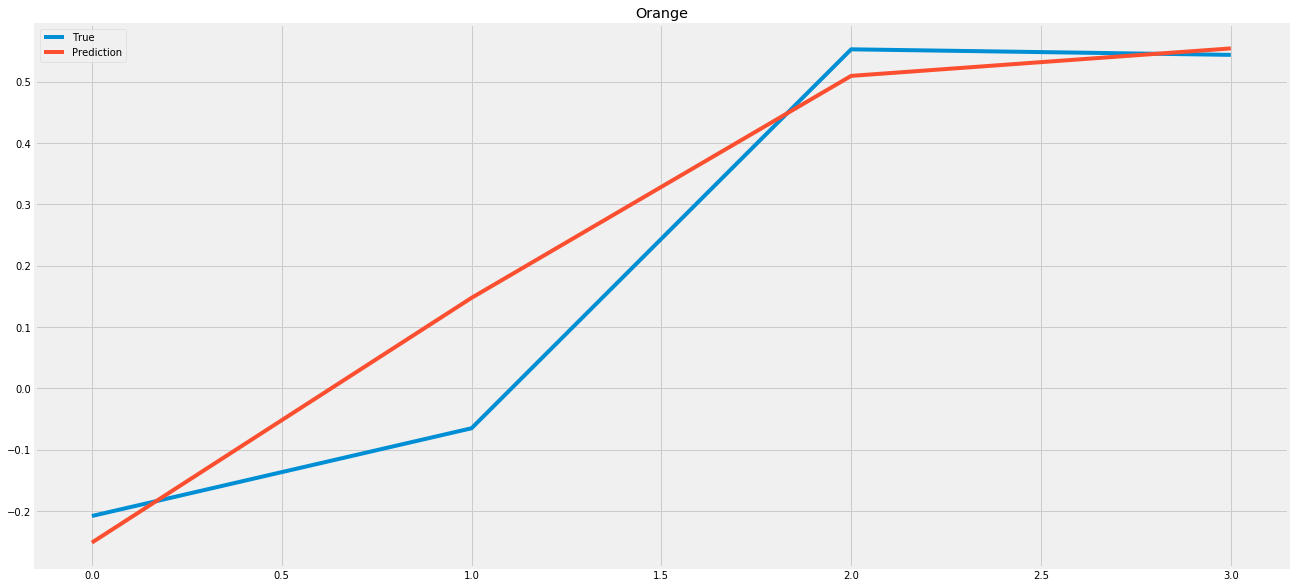

In [97]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
plt.title('Orange')
ax.legend()
plt.show()

In [98]:
pears_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Pears')]
pr_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Potato')].reset_index()
pr_2015_new = pr_2015[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_pr_2015 = pr_2015_new.rename(columns={"jan":"m1", "feb":"m2", "mar":"m3", "apr":"m4", "may":"m5", "jun":"m6", "jul":"m7","aug":"m8","sep":"m9","oct":"m10","nov":"m11", "dec":"m12"})
pr_2016 = export_all[(export_all['mktyr'] == 2016.0) & (export_all['product']=='Onion')].reset_index()
pr_2016_new = pr_2016[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_pr_2016 = pr_2016_new.rename(columns={"jan":"m13", "feb":"m14", "mar":"m15", "apr":"m16", "may":"m17", "jun":"m18", "jul":"m19","aug":"m20","sep":"m21","oct":"m22","nov":"m23", "dec":"m24"})
pr_2017 = export_all[(export_all['mktyr'] == 2017.0) & (export_all['product']=='Onion')].reset_index()
pr_2017_new = pr_2017[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_pr_2017 = pr_2017_new.rename(columns={"jan":"m25", "feb":"m26", "mar":"m27", "apr":"m28", "may":"m29", "jun":"m30", "jul":"m31","aug":"m32","sep":"m33","oct":"m34","nov":"m35", "dec":"m36"})
pr_2018 = export_all[(export_all['mktyr'] == 2018.0) & (export_all['product']=='Onion')].reset_index()
pr_2018_new = pr_2018[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_pr_2018 = pr_2018_new.rename(columns={"jan":"m37", "feb":"m38", "mar":"m39", "apr":"m40", "may":"m41", "jun":"m42", "jul":"m43","aug":"m44","sep":"m45","oct":"m46","nov":"m47", "dec":"m48"})
pr = ren_pr_2015.join([ren_pr_2016, ren_pr_2017, ren_pr_2018], how='outer')


In [99]:
trans_pr = pr.T 
pr_final = trans_pr.reset_index()
pr_data = pr_final.rename(columns={"index": "month", 0: "value"})
pr_data['mo'] = pr_data.index
pr_fin=pr_data[["mo", "value"]]
pr_fin.index = pr_fin.mo
pr_fin.drop('mo', axis=1, inplace=True)
pr_fin.to_csv('dset/pr.csv')

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [100]:
value = pr_fin["value"].values
seq_len = 10
sequence_length = seq_len + 1

result = []
for index in range(len(value) - sequence_length):
    result.append(value[index: index + sequence_length])

In [101]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((33, 10, 1), (4, 10, 1))

In [102]:
model = Sequential()

model.add(LSTM(10, return_sequences=True, input_shape=(10, 1)))

model.add(LSTM(24, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse',metrics=['mean_squared_error'],optimizer='nadam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 10, 10)            480       
_________________________________________________________________
lstm_18 (LSTM)               (None, 24)                3360      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 25        
Total params: 3,865
Trainable params: 3,865
Non-trainable params: 0
_________________________________________________________________


In [103]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=100)

Train on 33 samples, validate on 4 samples
Epoch 1/100
33/33 [==============================] - 5s 159ms/step - loss: 0.1010 - mean_squared_error: 0.1010 - val_loss: 0.1342 - val_mean_squared_error: 0.1342
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0955 - mean_squared_error: 0.0955 - val_loss: 0.1299 - val_mean_squared_error: 0.1299
Epoch 3/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0925 - mean_squared_error: 0.0925 - val_loss: 0.1301 - val_mean_squared_error: 0.1301
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0932 - mean_squared_error: 0.0932 - val_loss: 0.1318 - val_mean_squared_error: 0.1318
Epoch 5/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0892 - mean_squared_error: 0.0892 - val_loss: 0.1229 - val_mean_squared_error: 0.1229
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0873 - mean_squared_error: 0.0873 - val_loss: 0.1091 - val_mean_squared_err

33/33 [==============================] - 0s 2ms/step - loss: 0.0221 - mean_squared_error: 0.0221 - val_loss: 0.0146 - val_mean_squared_error: 0.0146
Epoch 52/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0221 - mean_squared_error: 0.0221 - val_loss: 0.0115 - val_mean_squared_error: 0.0115
Epoch 53/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0226 - mean_squared_error: 0.0226 - val_loss: 0.0171 - val_mean_squared_error: 0.0171
Epoch 54/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0233 - mean_squared_error: 0.0233 - val_loss: 0.0296 - val_mean_squared_error: 0.0296
Epoch 55/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0232 - mean_squared_error: 0.0232 - val_loss: 0.0160 - val_mean_squared_error: 0.0160
Epoch 56/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0215 - mean_squared_error: 0.0215 - val_loss: 0.0148 - val_mean_squared_error: 0.0148
Epoch 57/100
33/33 [=====================

In [104]:
model.save("pr_model_trained.h5")

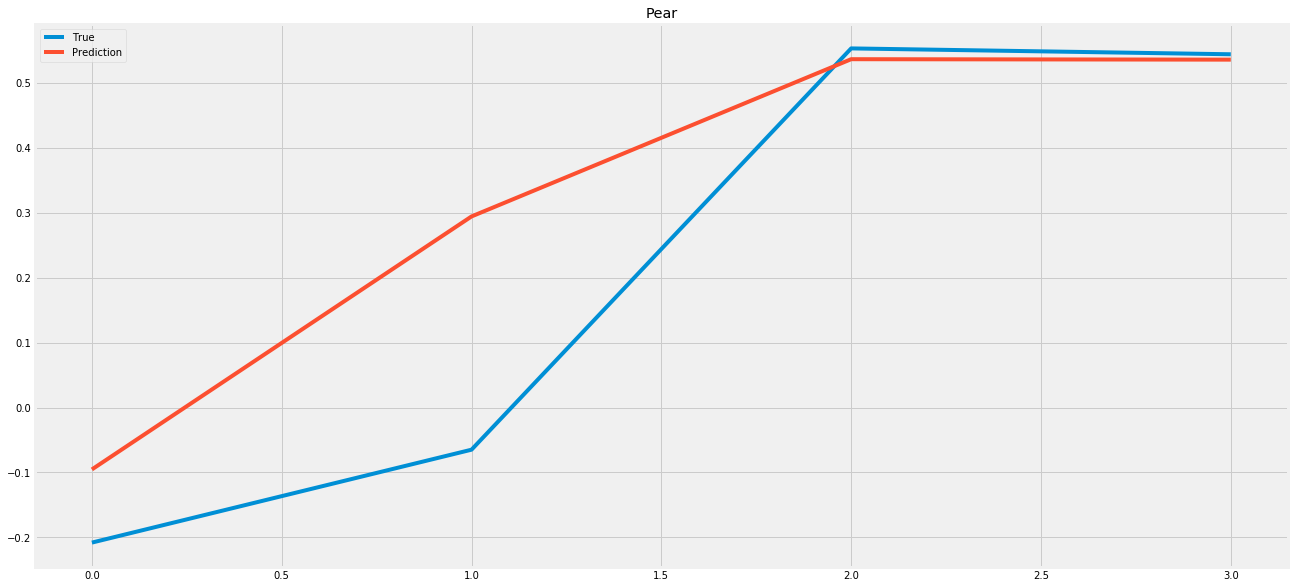

In [105]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
plt.title('Pear')
ax.legend()
plt.show()

In [106]:
strawberries_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Strawberries')]
str_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Potato')].reset_index()
str_2015_new = str_2015[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_str_2015 = str_2015_new.rename(columns={"jan":"m1", "feb":"m2", "mar":"m3", "apr":"m4", "may":"m5", "jun":"m6", "jul":"m7","aug":"m8","sep":"m9","oct":"m10","nov":"m11", "dec":"m12"})
str_2016 = export_all[(export_all['mktyr'] == 2016.0) & (export_all['product']=='Onion')].reset_index()
str_2016_new = str_2016[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_str_2016 = str_2016_new.rename(columns={"jan":"m13", "feb":"m14", "mar":"m15", "apr":"m16", "may":"m17", "jun":"m18", "jul":"m19","aug":"m20","sep":"m21","oct":"m22","nov":"m23", "dec":"m24"})
str_2017 = export_all[(export_all['mktyr'] == 2017.0) & (export_all['product']=='Onion')].reset_index()
str_2017_new = str_2017[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_str_2017 = str_2017_new.rename(columns={"jan":"m25", "feb":"m26", "mar":"m27", "apr":"m28", "may":"m29", "jun":"m30", "jul":"m31","aug":"m32","sep":"m33","oct":"m34","nov":"m35", "dec":"m36"})
str_2018 = export_all[(export_all['mktyr'] == 2018.0) & (export_all['product']=='Onion')].reset_index()
str_2018_new = str_2018[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_str_2018 = str_2018_new.rename(columns={"jan":"m37", "feb":"m38", "mar":"m39", "apr":"m40", "may":"m41", "jun":"m42", "jul":"m43","aug":"m44","sep":"m45","oct":"m46","nov":"m47", "dec":"m48"})
strw = ren_str_2015.join([ren_str_2016, ren_str_2017, ren_str_2018], how='outer')

In [107]:
trans_str = strw.T 
str_final = trans_str.reset_index()
str_data = str_final.rename(columns={"index": "month", 0: "value"})
str_data['mo'] = str_data.index
str_fin=str_data[["mo", "value"]]
str_fin.index = str_fin.mo
str_fin.drop('mo', axis=1, inplace=True)
str_fin.to_csv('dset/str.csv')

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [108]:
value = str_fin["value"].values
seq_len = 10
sequence_length = seq_len + 1

result = []
for index in range(len(value) - sequence_length):
    result.append(value[index: index + sequence_length])

In [109]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((33, 10, 1), (4, 10, 1))

In [110]:
model = Sequential()

model.add(LSTM(10, return_sequences=True, input_shape=(10, 1)))

model.add(LSTM(24, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', metrics=['mean_squared_error'], optimizer='nadam')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 10, 10)            480       
_________________________________________________________________
lstm_20 (LSTM)               (None, 24)                3360      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 25        
Total params: 3,865
Trainable params: 3,865
Non-trainable params: 0
_________________________________________________________________


In [111]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=100)

Train on 33 samples, validate on 4 samples
Epoch 1/100
33/33 [==============================] - 6s 180ms/step - loss: 0.1106 - mean_squared_error: 0.1106 - val_loss: 0.1512 - val_mean_squared_error: 0.1512
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 0.1044 - mean_squared_error: 0.1044 - val_loss: 0.1480 - val_mean_squared_error: 0.1480
Epoch 3/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0995 - mean_squared_error: 0.0995 - val_loss: 0.1360 - val_mean_squared_error: 0.1360
Epoch 4/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0951 - mean_squared_error: 0.0951 - val_loss: 0.1342 - val_mean_squared_error: 0.1342
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0918 - mean_squared_error: 0.0918 - val_loss: 0.1263 - val_mean_squared_error: 0.1263
Epoch 6/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0895 - mean_squared_error: 0.0895 - val_loss: 0.1271 - val_mean_squared_err

33/33 [==============================] - 0s 3ms/step - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0194 - val_mean_squared_error: 0.0194
Epoch 52/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0218 - mean_squared_error: 0.0218 - val_loss: 0.0168 - val_mean_squared_error: 0.0168
Epoch 53/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0212 - mean_squared_error: 0.0212 - val_loss: 0.0154 - val_mean_squared_error: 0.0154
Epoch 54/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0215 - mean_squared_error: 0.0215 - val_loss: 0.0201 - val_mean_squared_error: 0.0201
Epoch 55/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0220 - mean_squared_error: 0.0220 - val_loss: 0.0263 - val_mean_squared_error: 0.0263
Epoch 56/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0216 - val_mean_squared_error: 0.0216
Epoch 57/100
33/33 [=====================

In [112]:
model.save("str_model_trained.h5")

In [113]:
# model.compile(optimizer='adam', loss='mse', metrics=['mse', 'accuracy'])
# model.evaluate()

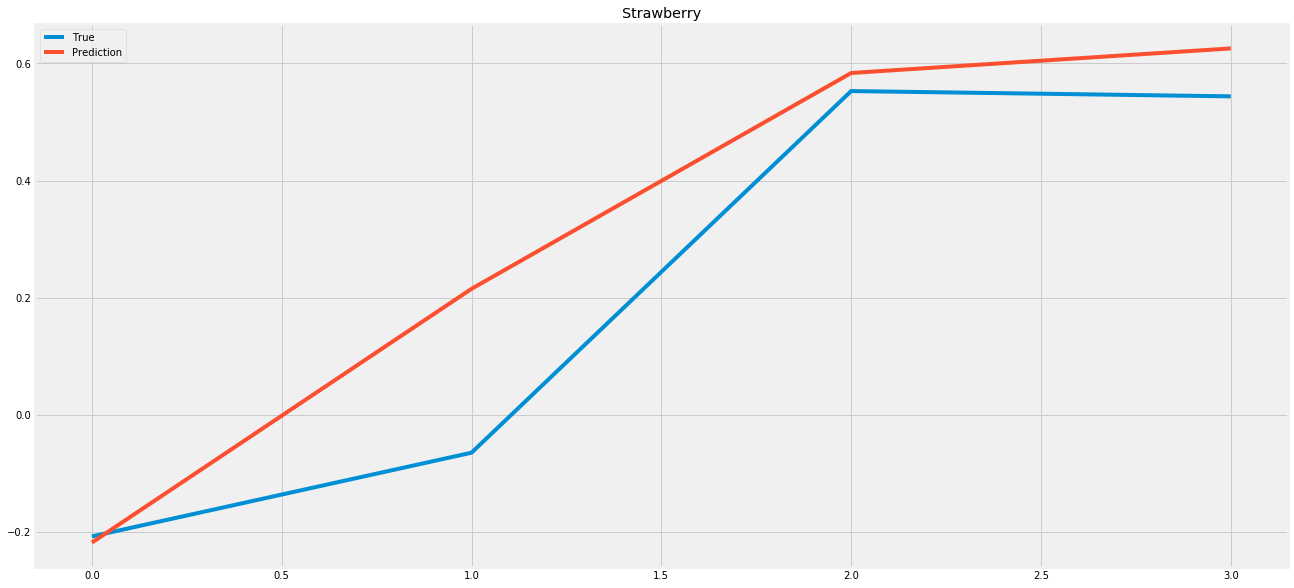

In [114]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
plt.title('Strawberry')
ax.legend()
plt.show()